**Skin Lesion Classification on balanced unsegmented using EfficientNet**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 29 05:33:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Loading files from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing the required libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB2
from PIL import Image
import cv2  
from google.colab.patches import cv2_imshow

In [ ]:
import pathlib
root_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced"
data_dir = pathlib.Path(root_path)

**Splitting the data into training and validation**

In [ ]:
batch_size=64

In [ ]:
img_height,img_width=256,256
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61875 files belonging to 8 classes.
Using 49500 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61875 files belonging to 8 classes.
Using 12375 files for validation.


In [ ]:
classnames = train_ds.class_names
classnames

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

**Visualizing the data**

In [ ]:
import cv2  
from google.colab.patches import cv2_imshow

(-0.5, 255.5, 255.5, -0.5)

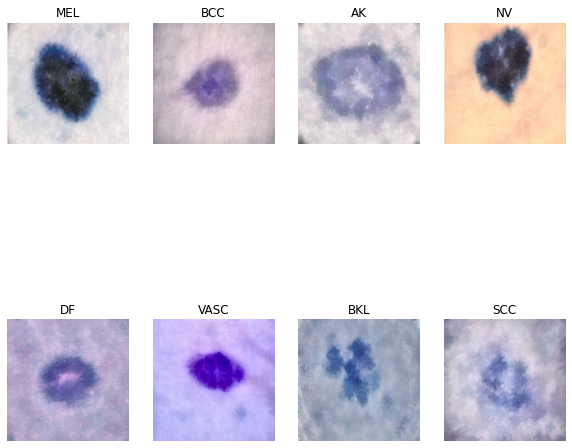

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,4,figsize=[10,10])

ax[0, 0].title.set_text('MEL')
ax[0, 1].title.set_text('BCC')
ax[0, 2].title.set_text('AK')
ax[0, 3].title.set_text('NV')

img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/MEL/ICIS_resampled_13.jpg')
ax[0, 0].imshow(img)
ax[0, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/BCC/ICIS_resampled_3034.jpg')
ax[0, 1].imshow(img)
ax[0, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/AK/ICIS_resampled_5932.jpg')
ax[0, 2].imshow(img)
ax[0, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/NV/ICIS_resampled_16.jpg')
ax[0, 3].imshow(img)
ax[0, 3].axis("off")

ax[1, 0].title.set_text('DF')
ax[1, 1].title.set_text('VASC')
ax[1, 2].title.set_text('BKL')
ax[1, 3].title.set_text('SCC')


img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/DF/ICIS_resampled_3443.jpg')
ax[1, 0].imshow(img)
ax[1, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/VASC/ICIS_resampled_3304.jpg')
ax[1, 1].imshow(img)
ax[1, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/BKL/ICIS_resampled_1299.jpg')
ax[1, 2].imshow(img)
ax[1, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/training_balanced/SCC/ICIS_resampled_4681.jpg')
ax[1, 3].imshow(img)
ax[1, 3].axis("off")

**Training the model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(256, 256, 3))
x = img_augmentation(inputs)  
model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(8, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
epochs = 20
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
774/774 [==============================] - 3513s 5s/step - loss: 1.8347 - accuracy: 0.4343 - val_loss: 1.4203 - val_accuracy: 0.4847
Epoch 2/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4355 - accuracy: 0.4758 - val_loss: 1.3784 - val_accuracy: 0.4992
Epoch 3/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4386 - accuracy: 0.4723 - val_loss: 1.3762 - val_accuracy: 0.4938
Epoch 4/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4463 - accuracy: 0.4690 - val_loss: 1.3705 - val_accuracy: 0.4954
Epoch 5/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4467 - accuracy: 0.4716 - val_loss: 1.4386 - val_accuracy: 0.4700
Epoch 6/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4625 - accuracy: 0.4652 - val_loss: 1.4213 - val_accuracy: 0.4873
Epoch 7/20
774/774 [==============================] - 153s 197ms/step - loss: 1.4558 - accuracy: 0.4675 - val_loss: 1.4210 - v

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/efficientnet_model_bal.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
model.trainable = True
epochs=20
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
774/774 [==============================] - 683s 865ms/step - loss: 1.2157 - accuracy: 0.5502 - val_loss: 1.0439 - val_accuracy: 0.6086
Epoch 2/20
774/774 [==============================] - 668s 863ms/step - loss: 0.9000 - accuracy: 0.6656 - val_loss: 0.8748 - val_accuracy: 0.6739
Epoch 3/20
774/774 [==============================] - 668s 863ms/step - loss: 0.7531 - accuracy: 0.7199 - val_loss: 0.7723 - val_accuracy: 0.7162
Epoch 4/20
774/774 [==============================] - 669s 863ms/step - loss: 0.6456 - accuracy: 0.7611 - val_loss: 0.6942 - val_accuracy: 0.7457
Epoch 5/20
774/774 [==============================] - 669s 864ms/step - loss: 0.5650 - accuracy: 0.7911 - val_loss: 0.6339 - val_accuracy: 0.7686
Epoch 6/20
774/774 [==============================] - 670s 864ms/step - loss: 0.4994 - accuracy: 0.8143 - val_loss: 0.5753 - val_accuracy: 0.7906
Epoch 7/20
774/774 [==============================] - 668s 862ms/step - loss: 0.4381 - accuracy: 0.8413 - val_loss: 0.5512 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/efficientnet_model_bal1.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/efficientnet_model_bal1.h5')

In [ ]:
#50 epochs

epochs=10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
774/774 [==============================] - 677s 873ms/step - loss: 0.1070 - accuracy: 0.9617 - val_loss: 0.4247 - val_accuracy: 0.8813
Epoch 2/10
774/774 [==============================] - 676s 872ms/step - loss: 0.1023 - accuracy: 0.9637 - val_loss: 0.4273 - val_accuracy: 0.8817
Epoch 3/10
774/774 [==============================] - 676s 873ms/step - loss: 0.0933 - accuracy: 0.9665 - val_loss: 0.4185 - val_accuracy: 0.8886
Epoch 4/10
774/774 [==============================] - 676s 873ms/step - loss: 0.0932 - accuracy: 0.9665 - val_loss: 0.4506 - val_accuracy: 0.8807
Epoch 5/10
774/774 [==============================] - 676s 873ms/step - loss: 0.0877 - accuracy: 0.9691 - val_loss: 0.4298 - val_accuracy: 0.8868
Epoch 6/10
774/774 [==============================] - 675s 872ms/step - loss: 0.0818 - accuracy: 0.9712 - val_loss: 0.4484 - val_accuracy: 0.8855
Epoch 7/10
774/774 [==============================] - 676s 872ms/step - loss: 0.0794 - accuracy: 0.9718 - val_loss: 0.4202 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/65_efficientnet_model_bal1.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/65_efficientnet_model_bal1.h5')
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']   

In [ ]:
y_val = np.zeros(12375, dtype=object)
x_val = np.zeros([12375, 256, 256, 3])
i=0
j=0

for x,y in val_ds:
  for k in x:
    x_val[j, :,:] = k
    j+=1
  for p in y:
    y_val[i] = p
    i+=1

y_label = np.empty(12375, dtype=object)
for i in range(len(y_val)):
  y_label[i] = np.array(y_val[i])

In [ ]:
pred=model.predict(x_val,batch_size=64, verbose=1)

194/194 [==============================] - 233s 1s/step


In [ ]:
y_true=[]
for i in range(len(y_label)):
  y_true.append(classnames[y_label[i]])

In [ ]:
output_class=[]
for i in range(len(pred)):
  output_class.append(classnames[np.argmax(pred[i])])

**Displaying few predicted samples**

In [ ]:
for i in range(50):
  print("\nImage : ", i+1)
  cv2_imshow(x_val[i])
  print("The actual class is", y_true[i])
  print("The predicted class is", output_class[i]) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Crct_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
Total_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
for i in range(len(pred)):
  Total_Counter[y_true[i]]+=1
  if(y_true[i]==output_class[i]):
    Crct_Counter[y_true[i]]+=1

**Displaying class-wise accuracies**

In [ ]:
print("Class_name \t\t Crct_pred \t\t  tot_images \t\t Accuracy")
print("AK\t\t\t",Crct_Counter['AK'],"\t\t\t ",Total_Counter['AK'],"\t\t\t",round(Crct_Counter['AK']/Total_Counter['AK'],2))
print("MEL\t\t\t",Crct_Counter['MEL'],"\t\t\t ",Total_Counter['MEL'],"\t\t\t",round(Crct_Counter['MEL']/Total_Counter['MEL'],2))
print("BCC\t\t\t",Crct_Counter['BCC'],"\t\t\t ",Total_Counter['BCC'],"\t\t\t",round(Crct_Counter['BCC']/Total_Counter['BCC'],2))
print("NV\t\t\t",Crct_Counter['NV'],"\t\t\t ",Total_Counter['NV'],"\t\t\t",round(Crct_Counter['NV']/Total_Counter['NV'],2))
print("BKL\t\t\t",Crct_Counter['BKL'],"\t\t\t ",Total_Counter['BKL'],"\t\t\t",round(Crct_Counter['BKL']/Total_Counter['BKL'],2))
print("DF\t\t\t",Crct_Counter['DF'],"\t\t\t ",Total_Counter['DF'],"\t\t\t",round(Crct_Counter['DF']/Total_Counter['DF'],2))
print("VASC\t\t\t",Crct_Counter['VASC'],"\t\t\t ",Total_Counter['VASC'],"\t\t\t",round(Crct_Counter['VASC']/Total_Counter['VASC'],2))
print("SCC\t\t\t",Crct_Counter['SCC'],"\t\t\t ",Total_Counter['SCC'],"\t\t\t",round(Crct_Counter['SCC']/Total_Counter['SCC'],2))

Class_name 		 Crct_pred 		  tot_images 		 Accuracy
AK			 1262 			  1405 			 0.9
MEL			 980 			  1403 			 0.7
BCC			 1178 			  1420 			 0.83
NV			 2373 			  2552 			 0.93
BKL			 1152 			  1428 			 0.81
DF			 1339 			  1351 			 0.99
VASC			 1409 			  1413 			 1.0
SCC			 1340 			  1403 			 0.96


**Displaying the classifictaion report**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
print(classification_report(y_true, output_class, target_names=target_names))

              precision    recall  f1-score   support

          AK       0.91      0.90      0.90      1405
         BCC       0.85      0.83      0.84      1420
         BKL       0.85      0.81      0.83      1428
          DF       0.95      0.99      0.97      1351
         MEL       0.84      0.70      0.76      1403
          NV       0.87      0.93      0.90      2552
         SCC       0.89      0.96      0.92      1403
        VASC       0.98      1.00      0.99      1413

    accuracy                           0.89     12375
   macro avg       0.89      0.89      0.89     12375
weighted avg       0.89      0.89      0.89     12375



**Displaying the confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, output_class, labels=target_names)

array([[1262,   58,   26,    4,   12,    3,   40,    0],
       [  46, 1178,   43,   37,   25,   27,   54,   10],
       [  35,   55, 1152,    8,   65,   73,   35,    5],
       [   0,    3,    5, 1339,    0,    2,    1,    1],
       [  21,   38,   80,   11,  980,  240,   29,    4],
       [   2,   41,   46,    2,   85, 2373,    1,    2],
       [  19,   20,   11,    5,    6,    2, 1340,    0],
       [   0,    1,    0,    2,    0,    1,    0, 1409]])